# S&P Industry Data Analyst - Business Analysis

### Problem Statement:
Thank you for participating. The table in the attached file shows 400 rows of sample data with the kinds of data elements that we see in the automotive domain. Each row represents a purchase of a vehicle by an individual customer. This dataset has been constructed to contain the types of strengths and weaknesses that are frequently part of any data analytics or data science project. Please use any data analysis environment you prefer (e.g. Excel, a Python notebook, etc.), perform some analysis, and create a brief presentation or document to communicate what you found. Below are some of the questions we are interested in, though we are happy to review any additional findings you uncover in your study.

    1. What are some of the problems with these data elements? How did you go about identifying those?
    2. What are some potential ways to reduce the impact of these problems?
    3. What are some business cases for using data like this? What are some examples?
    4. What additional data elements might you try to access to enhance this dataset?
    5. What are some of the relationships you see in the dataset? How would you use those relationships?


### Now let's import the necessary libraries and read in the data.
Note: to run this notebook, the notebook and the .xlsx data file will need to be in the same directory. (or you can change the argument in the 'pd.read_excel' function to match the appropriate path on your machine)

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_excel('./Industry Data Analyst - Business Analysis - Final.xlsx', sheet_name='Data')

Let's look at the first few rows.

In [3]:
df.head(10)

,RowId,Date,Mileage,DownPayment,Msrp,MonthlyPayment,ExteriorColor,CustomerEstimatedIncome
0,1,2021-01-01,0,NaN,NaN,394.000,NaN,0
1,2,2021-01-01,23,1423.035,57529.0,805.761,BLACK,223000
2,3,2021-01-01,0,NaN,NaN,535.000,NaN,0
3,4,2021-01-01,13,3680.000,40112.0,320.080,GR,170000
4,5,2021-01-01,0,NaN,NaN,511.000,NaN,0
5,6,2021-01-01,0,NaN,NaN,563.000,NaN,0
6,7,2021-01-01,0,NaN,NaN,495.000,NaN,0
7,8,2021-01-01,0,NaN,NaN,486.000,NaN,0
8,9,2021-01-01,0,NaN,NaN,476.000,NaN,0
9,10,2021-01-01,37,1372.850,47586.0,669.710,GRAY,193000


Here's what jumps out at me immediately:

    1. The RowId column is likely to cause confusion. In my zero-indexed dataframe, RowId 1 is at index 0. In Excel it'll be the other way around and the column names will be row 1, putting RowId 1 in row 2. Without a unique identifier for each transaction, it may be worth keeping the column just for ease of referencing a particular transaction if needed, but it'll be important to make sure everyone isn't getting RowId confused with index when talking about the data.

    2. There are NaN's in multiple columns. Not surprising, but it's good to know there's data missing, and we'll need to keep in mind that many models won't play nice with those if we try to run regressions, etc. For now we'll leave them as is and decide later if we want to drop some or impute those values with the mean or even something more exotic like using a K-Nearest-Neighbors unsupervised model to find similar rows and impute the values from there.

    3. MSRP is rounded to one decimal place, while DownPayment and MonthlyPayment are rounded to three. DownPayment and MonthlyPayment also have a value in the third decimal place, which doesn't make sense when these are in dollars. Most likely these should just be truncated to two decimal places, but it would also be worth looking into what the cause of that is and make sure some rows don't have the decimal in the wrong place.
    
    4. The color "BLACK" is spelled out, while the abbreviation "GR" is also used. Need to look more closely at how colors are broken down.

First, let's make sure all the data types are what they seem.

In [4]:
df.dtypes

RowId                               int64
Date                       datetime64[ns]
Mileage                             int64
DownPayment                       float64
Msrp                              float64
MonthlyPayment                    float64
ExteriorColor                      object
CustomerEstimatedIncome             int64
dtype: object

Good. The dates are actual datetimes, the float and int columns are what they should be, and the ExteriorColor is an object. 

### Let's start our EDA by finding out how many NaN's we have in each column.

## NAN's

In [5]:
# Get number of NaN's in each column and also express as percentage. 
for col in df.columns:
    nans = df[col].isna().sum()
    percent_nans = str(nans/len(df)*100) + '%'
    print(col,':', nans,',',percent_nans)

RowId : 0 , 0.0%
Date : 0 , 0.0%
Mileage : 0 , 0.0%
DownPayment : 37 , 9.25%
Msrp : 24 , 6.0%
MonthlyPayment : 5 , 1.25%
ExteriorColor : 24 , 6.0%
CustomerEstimatedIncome : 0 , 0.0%


In [6]:
# List is in descending order from most NaN's to least.
col_names = ['DownPayment','Msrp','ExteriorColor','MonthlyPayment']
for comb in itertools.combinations(col_names,2):
    # Count the number of times both columns are NaN
    both_nan = np.where(df[[comb[0],comb[1]]].isnull().all(1),1,0).sum()
    # Number of NaN's in the column with less (or equal, technically) 
    max_possible = df[comb[1]].isna().sum()
    perc = str(both_nan / max_possible*100)+'%'
    print("When", comb[1],'is NaN,',perc,'of the time',comb[0],'is also NaN')

When Msrp is NaN, 100.0% of the time DownPayment is also NaN
When ExteriorColor is NaN, 100.0% of the time DownPayment is also NaN
When MonthlyPayment is NaN, 100.0% of the time DownPayment is also NaN
When ExteriorColor is NaN, 100.0% of the time Msrp is also NaN
When MonthlyPayment is NaN, 100.0% of the time Msrp is also NaN
When MonthlyPayment is NaN, 100.0% of the time ExteriorColor is also NaN


In [7]:
# List is in ascending order from least NaN's to most.
col_names = ['MonthlyPayment','ExteriorColor','Msrp','DownPayment']
for comb in itertools.combinations(col_names,2):
    # Count the number of times both columns are NaN
    both_nan = np.where(df[[comb[0],comb[1]]].isnull().all(1),1,0).sum()
    # Number of NaN's in the column with less (or equal, technically) 
    max_possible = df[comb[1]].isna().sum()
    #calculate
    perc = str(round(both_nan / max_possible*100,2))+'%'
    print("When", comb[1],'is NaN,',perc,'of the time',comb[0],'is also NaN')

When ExteriorColor is NaN, 20.83% of the time MonthlyPayment is also NaN
When Msrp is NaN, 20.83% of the time MonthlyPayment is also NaN
When DownPayment is NaN, 13.51% of the time MonthlyPayment is also NaN
When Msrp is NaN, 100.0% of the time ExteriorColor is also NaN
When DownPayment is NaN, 64.86% of the time ExteriorColor is also NaN
When DownPayment is NaN, 64.86% of the time Msrp is also NaN


It may not be immediately apparent, but what this tells us is:
- If MonthlyPayment is NAN; MSRP, ExteriorColor, and DownPayment are also NAN.
- MSRP and ExteriorColor are NAN in the exact same rows.
- In the rows where MSRP/ExteriorColor are NAN, DownPayment is also NAN.
- Because of these last three insights, we know that if we were to drop all rows where DownPayment is NAN, we would eliminate all NAN's from the data.

As previously mentioned, besides dropping the data, we could use one of several methods for imputing those missing values if desired. I won't do that here for the sake of continuing to work with the data in its original state, but for the sake of demonstrating my skill, I will say that the easy way to impute the column mean which might be useful for keeping all of the rows without skewing a regression too wildly would be to use SimpleImputer from the SKLearn library. Less efficiently, using a loop to calculate the column mean and applying it with fillna() would also work.

### Let's move onto the next task of looking more closely at the ExteriorColor column

## ExteriorColor

In [8]:
df.ExteriorColor.unique()

array([nan, 'BLACK', 'GR', 'GRAY', 'WHITE', 'RX', 'SILVER', 'GX', 1500,
       'SA', 'SX', 'WB', 'WY', 'BK', 'RED', 'BX', 'GREEN', 'GREY', 'BS',
       'SL', 'WV', 'WX', 'BROWN', 'SPECIAL', 'BR', 'BLK', 'BLUE', 'RB',
       'WH', 'BM', 'RE', 'GV', 'BV', 'WA'], dtype=object)

So first we see the NAN's, which we already knew, but then we see colors both written normally as well as abbreviated. Gray is also written as both "Grey" and "Gray." Finally we have 1500 in there which is most likely either a mistake, or some kind of paint code. Either way, it's not even a string, it's actually an integer.

Normally, this is the point where I'd dive into the specifics of the data and try to get an understanding of things like "where did 1500 come from?" and "what color is RX?" but that's not possible in this case, so let me instead just quickly turn 'BLACK', 'BLK', and 'BK' all into just 'BLACK', turn 'GREY' into 'GRAY' (though leaving alone 'GR' just because that could also mean 'Green'), and make 1500 into a string rather than an integer so it'll be easier to work with.

In [9]:
ColorDict = {'BLK':'BLACK','BK':'BLACK', 1500:'1500', 'GREY':'GRAY'}
df['ExteriorColor'].replace(ColorDict, inplace=True)

And quickly check that it did work:

In [10]:
df.ExteriorColor.unique()

array([nan, 'BLACK', 'GR', 'GRAY', 'WHITE', 'RX', 'SILVER', 'GX', '1500',
       'SA', 'SX', 'WB', 'WY', 'RED', 'BX', 'GREEN', 'BS', 'SL', 'WV',
       'WX', 'BROWN', 'SPECIAL', 'BR', 'BLUE', 'RB', 'WH', 'BM', 'RE',
       'GV', 'BV', 'WA'], dtype=object)

Excellent. Now you can see that 'GREY' 'BLK' and 'BK' no longer exist in the data and 1500 is a string rather than an integer.

## Let's move on to rounding all the columns in a way that makes sense

Looking at the data in Excel, it's clear that the way the numbers are rounded varies greatly. Some DownPayment rows don't have a decimal at all, while others have 3 places after the decimal, etc.

Again, it's possible that some of the decimals are in the wrong place and the correct numbers involve moving the decimal, rather than rounding, but by comparing DownPayment to MSRP and MonthlyPayment in a couple of rows, it appears as ifthe decimals are in the correct place and the extra places past the decimal show up for some other reason. Therefore, it's likely that simply rounding the decimals to 2 places is a reasonable approach.

I believe that Pandas put the decimal place into the Msrp column when it's actually an int, but I'll run a quick line to ensure that there isn't one row somewhere that actually has a decimal place.

In [11]:
# getting the percentage of times that msrp as an integer is the same as msrp in its current floating point state.
np.where(df['Msrp'].dropna().astype(int)==df['Msrp'].dropna(),1,0).sum()/len(df['Msrp'].dropna())

1.0

Good, 1.0 means Msrp is the same whether it's an INT or FLOAT. With that out of the way, let's change Msrp to an integer, and truncate DownPayment and MonthlyPayment to two decimal places.

In [12]:
df['DownPayment']=df['DownPayment'].round(2)
df['MonthlyPayment']=df['MonthlyPayment'].round(2)
df['Msrp']=df['Msrp'].astype('Int64')

In [13]:
df.head()

,RowId,Date,Mileage,DownPayment,Msrp,MonthlyPayment,ExteriorColor,CustomerEstimatedIncome
0,1,2021-01-01,0,NaN,<NA>,394.00,NaN,0
1,2,2021-01-01,23,1423.04,57529,805.76,BLACK,223000
2,3,2021-01-01,0,NaN,<NA>,535.00,NaN,0
3,4,2021-01-01,13,3680.00,40112,320.08,GR,170000
4,5,2021-01-01,0,NaN,<NA>,511.00,NaN,0


## Now that our data is all clean, let's actually do some analysis.

In [14]:
df.Date.value_counts()

2021-01-01    395
2021-02-02      5
Name: Date, dtype: int64

So most of the data is from Jan. 1st, 2021 while 5 of the rows are from Feb. 2nd. This could be correct, or it could be typos, or it could be that the data is checked at the beginning of the month and there then isn't really data that shows up in the middle of the month. There's no way to tell in this case. But let's look at the 5 rows from Feb. 2nd to see if they're different.

In [15]:
df.loc[df['Date']=='2021-02-02']

,RowId,Date,Mileage,DownPayment,Msrp,MonthlyPayment,ExteriorColor,CustomerEstimatedIncome
378,379,2021-02-02,0,NaN,<NA>,NaN,NaN,0
380,381,2021-02-02,0,NaN,<NA>,NaN,NaN,0
392,393,2021-02-02,0,NaN,<NA>,NaN,NaN,0
396,397,2021-02-02,0,NaN,<NA>,NaN,NaN,0
398,399,2021-02-02,0,NaN,<NA>,NaN,NaN,0


There is no usable data for those rows, so I think it's safe to say we should just drop them.

In [16]:
df = df.loc[df['Date']=='2021-01-01']
df.Date.value_counts()

2021-01-01    395
Name: Date, dtype: int64

Perfect. Now let's get an idea of the spread of values in the other columns.

In [17]:
DownPayment_breakdown=pd.DataFrame(data=[df['DownPayment'].isna().sum(),len(df.loc[df['DownPayment']==0]),len(df.loc[df['DownPayment']>0])],index=['Null','Zero','Greater Than Zero'],columns=['Number'])
DownPayment_breakdown=DownPayment_breakdown.reset_index()
DownPayment_breakdown

,index,Number
0,Null,32
1,Zero,4
2,Greater Than Zero,359


Just to quickly visualize how much data is missing, versus how many people didn't put anything down, versus how many people did use a down payment:

In [18]:
alt.Chart(DownPayment_breakdown).mark_bar().encode(
    x='index',
    y='Number'
)

alt.Chart(...)

Now let's look at the distribution of down payments (specifically for those who actually made a down payment). First with a larger bin size, then with a smaller bin size to get a more granular view of the distribution.

In [19]:

ch1=alt.Chart(df.loc[df['DownPayment']>0]).mark_bar().encode(
    alt.X('DownPayment:O', bin=alt.Bin(step=5000)),
    y='count()'
)
ch2=alt.Chart(df.loc[df['DownPayment']>0]).mark_bar().encode(
    alt.X('DownPayment:O', bin=alt.Bin(step=1000)),
    y='count()'
)
ch1|ch2

alt.HConcatChart(...)

...and likewise with the other numeric columns

In [20]:
ch=alt.Chart(df).mark_bar().encode(
    alt.X('Msrp', bin=alt.Bin(step=2000)),
    y='count()'
)
ch

alt.Chart(...)

In [21]:
ch=alt.Chart(df).mark_bar().encode(
    alt.X('MonthlyPayment', bin=True),
    y='count()'
)
ch

alt.Chart(...)

That doesn't seem right, let's check out those high numbers and see what's going on.

In [22]:
df.loc[df['MonthlyPayment']>1000]

,RowId,Date,Mileage,DownPayment,Msrp,MonthlyPayment,ExteriorColor,CustomerEstimatedIncome
198,199,2021-01-01,53,1880.13,53695,1043.55,BLACK,212000
262,263,2021-01-01,3,1109.69,42863,30915.00,BLACK,179000
268,269,2021-01-01,32,837.24,33931,35500.00,WH,150000


The first one actually seems reasonable. Financing a little over $50k and having a monthly payment around $1000 could be correct. The most likely problem with the other two rows is that they're off by two decimal places. To know that for certain, we'd need to know the loan term or rate, but for the sake of taking our best guess, let me divide those monthly payments by 100 to bring them in the range of the others. As always, if more information were available, I would dig in further to ensure that was the most correct course of action before making any changes to the data by hand (which in general is a bad practice).

In [23]:
df.at[262,'MonthlyPayment']=309.15
df.at[268,'MonthlyPayment']=355.00
df.loc[df['MonthlyPayment']>1000]

,RowId,Date,Mileage,DownPayment,Msrp,MonthlyPayment,ExteriorColor,CustomerEstimatedIncome
198,199,2021-01-01,53,1880.13,53695,1043.55,BLACK,212000


There, now it's fixed.

In [24]:
ch=alt.Chart(df).mark_bar().encode(
    alt.X('MonthlyPayment', bin=alt.Bin(step=50)),
    y='count()'
)
ch

alt.Chart(...)

Now, rather than running a bunch of regressions, to save myself some work I'm going to make a pair plot that will help show some of the relationships in the data. First I'm going to construct a couple of features that hopefully will give some additional insight though.

In [25]:
# The percent (as a decimal) of someone's income that they spend on the car if they pay MSRP.
df['MsrpIncomeRatio']=df['Msrp'] / df['CustomerEstimatedIncome']
# The percent of the MSRP that someone puts down when buying the car.
df['DownPayRatio']=df['DownPayment'] / df['Msrp']

In [26]:
df.head(10)

,RowId,Date,Mileage,DownPayment,Msrp,MonthlyPayment,ExteriorColor,CustomerEstimatedIncome,MsrpIncomeRatio,DownPayRatio
0,1,2021-01-01,0,NaN,<NA>,394.00,NaN,0,<NA>,<NA>
1,2,2021-01-01,23,1423.04,57529,805.76,BLACK,223000,0.257978,0.024736
2,3,2021-01-01,0,NaN,<NA>,535.00,NaN,0,<NA>,<NA>
3,4,2021-01-01,13,3680.00,40112,320.08,GR,170000,0.235953,0.091743
4,5,2021-01-01,0,NaN,<NA>,511.00,NaN,0,<NA>,<NA>
5,6,2021-01-01,0,NaN,<NA>,563.00,NaN,0,<NA>,<NA>
6,7,2021-01-01,0,NaN,<NA>,495.00,NaN,0,<NA>,<NA>
7,8,2021-01-01,0,NaN,<NA>,486.00,NaN,0,<NA>,<NA>
8,9,2021-01-01,0,NaN,<NA>,476.00,NaN,0,<NA>,<NA>
9,10,2021-01-01,37,1372.85,47586,669.71,GRAY,193000,0.24656,0.02885


c:\Users\Kozto\Desktop\Echotrail\env1\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Kozto\Desktop\Echotrail\env1\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
c:\Users\Kozto\Desktop\Echotrail\env1\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Kozto\Desktop\Echotrail\env1\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed objec

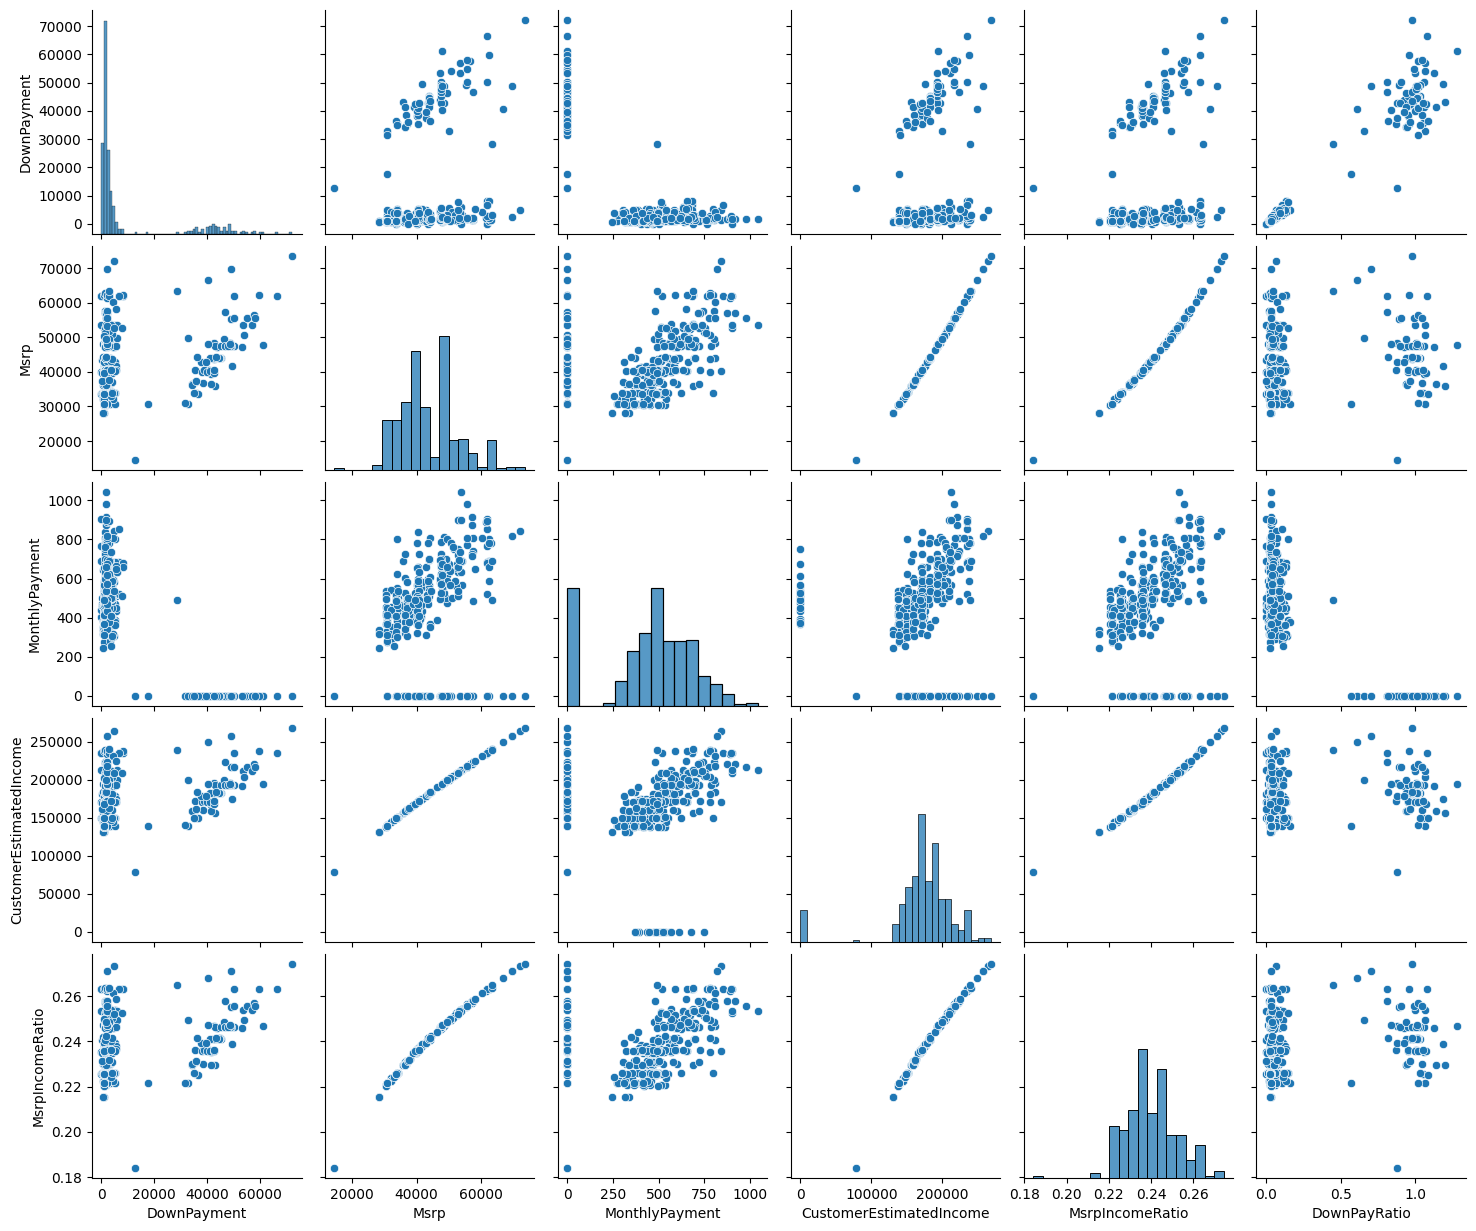

In [27]:
sns.pairplot(df,x_vars=['DownPayment','Msrp','MonthlyPayment','CustomerEstimatedIncome','MsrpIncomeRatio','DownPayRatio'],y_vars=['DownPayment','Msrp','MonthlyPayment','CustomerEstimatedIncome','MsrpIncomeRatio'])

And just to fit one actual regression and get an idea of how income affects MSRP...

In [28]:
df1 = df.dropna()
X = df1[['CustomerEstimatedIncome']]
y = df1['Msrp']
reg = LinearRegression().fit(X,y)
reg.coef_

array([0.3236776])

# Summary:

    1. What are some of the problems with these data elements? How did you go about identifying those?
    
There are many rows missing data. 37 rows are missing the down payment. Of those 37, 24 are missing MSRP and exterior color. And of those 24, 5 are missing monthly payment. A second problem is that the labels for exterior colors are not consistent. There are two spellings for "gray" and there are many abbreviations that overlap for various colors. There is also a color called "1500" which is likely either a paint code or a mistake. Thirdly, the decimals in the columns for down payment and monthly payment are inconsistent or incorrect or both. Fourth, there are 5 rows that are labeled as being from 2/2/2021 rather than 1/1/2021 like the rest of the data. That's not problematic, but when combined with the fact that those 5 rows have no usable data other than the date, I would hypothesize that this is a mistake in some way and the rows could be dropped from the data without impacting results. Lastly, there are a handful of numbers that don't make logical sense. There are a couple of monthly payments that are orders of magnitude larger than what makes sense for the amount financed. There are also two mileages that don't make sense under any normal conditions. And there are 33 occurrences of a down payment larger than the MSRP. There are scenarios where that is possible. Either a customer paying cash at MSRP and also needing to pay taxes or fees, or a customer who was 'upside down' in their last vehicle which they're trading in. But it's doubtful that those scenarios account for all of the 33 occurrences.

In order to identify these problems, I first examined a sample of the data by hand. Realistically though, all these problems would have been caught even without doing that. I always begin data analysis by looking at how much data is missing in each column mainly using methods like __.isna()__ in pandas or __isnull()__ in numpy. Then for the categorical columns for exterior color and date (which obviously isn't categorical, but ended up basically being ordinal with only two dates) I used the padas methods __.unique()__ and __value_counts()__ to view the different values that occurred which allowed me to notice that there were only two dates and also see the overlapping color abbreviations. Lastly, to further examine the numerical columns, I used a combination of the pandas method __.describe()__, making visualizations of the distributions, and then pulling subsets of the the data for more careful examination (e.g. using __.loc()__ to look at rows where monthly payment was >$1000). The most important thing I'd like to point out with all of this is that I didn't do anything with this dataset that wouldn't also work for a dataset 100 times as large.

    2. What are some potential ways to reduce the impact of these problems?

For the NANs, there are a few ways to approach them. Dropping rows with NANs is one option, but we risk losing important data or drawing incorrect conclusions if the rows we drop are not independent from the underlying distribution. It's impossible to make a real educated decision about dropping rows without understanding more about the nature of how the data is cultivated. In this case though, I believe that dropping the rows from 2/2/201 which don't have any other data in them is a safe bet. Other rows which are only missing one or three columns of data (no rows are missing exactly two) are harder to decide on dropping. Other strategies would be to impute that missing data using the column mean or median, or more elaborately, using an unsupervised machine learning K-Nearest-Neighbors imputer to impute the missing data based on similar rows. For the exterior color column most of the abbreviations can be combined with their non-abbreviated counterpart, for example changing "BK" and "BLK" to both be "BLACK." More information would likely be needed to determine what to do with the "1500" designation in that column though. Lastly, for the numbers that are outside of reasonable ranges, more information would be needed to know how to best proceed. Moving decimal points was an easy way to bring some of those into logical ranges and would be an understandable mistake in the data, however manipulating the data by hand is always a last resort and is not very reproducible. Determining an algorithm can help make it more reproducible (e.g. "any monthly payment >$10,000 gets divided by 100") but that is still not ideal, and dropping those rows entirely should also be considered.

    3. What are some business cases for using data like this? What are some examples?

There are many reasons this data could be helpful for a variety of businesses. I know from experience that one of the areas in car sales which makes significant money, and thus warrants significant analysis is the financing process. With this data we can immediately find the number of people who use financing and the amount (either in dollars or percentage of income) that they finance. In car sales, having an understanding of what income levels are associated with different MSRP's could also be helpful so that a business could know exactly what income bracket they should be trying to market to for differently priced cars. One last thing that comes to mind is figuring out what colors are purchased more in what MSRP ranges or customer income brackets to let manufacturers know what colors they should consider producing more of on which cars. We'd have to be careful with that however, since only colors that have already been produced can be sold. So if people really want an expensive car in purple, but no one currently produces an expensive car in purple, it won't show up in the data.

    4. What additional data elements might you try to access to enhance this dataset?

The first one that comes to mind is the loan details. Specifically the APR, or loan term, or both. Although just one of those would suffice as you could then calculate the other. Beyond that, I would probably go for details about the car that was purchased. It would allow analysis of what types of cars are being bought, whether that's by brand or vehicle type or any other number of factors. It would also allow for looking at correlations between a buyer's income level and the type of car they're purchasing. With further analysis, we could begin to even form a narrative about which buyers are wiser with their money based on paying cash or financing at a rate below inflation, and the type of gas mileage they could expect from the car they purchased as well as the estimated depreciation of that car.

    5. What are some of the relationships you see in the dataset? How would you use those relationships?
    
__Disclaimer__: Everything I'm about to say is true __on average__, I'm not going to include the words "on average" in every line for the sake of brevity, but you can assume that not every single person fits every single pattern I discuss.

The first and most obvious is that CustomerEstimatedIncome and Msrp are highly correlated, which makes sense. People with more money buy higher priced cars. I took that observation one additional level and when comparing income to the percentage of income the msrp of the car is for a person (msrp divided by estimated customer income), we can see that wealthier people not only purchase higher priced cars, but they actually purchase cars that are a higher percentage of their income. They do so at a decreasing rate though (i.e. if making $10k extra increases the percentage of income you spend on a car by 2.5%, making another $10k extra might only increase the percent of your income that you spend by 1.7%; an increase, but at a decreasing rate). Another relationship that we can see is that as estimated customer income increases, monthly payment increases assuming the car isn't paid for in cash. That makes sense when considering that the price of the car tends to go up with income, however it's interesting to note that down payment doesn't go up equally with the price of the car, which would result in equal monthly payments across income levels. I might just guess that many of those wealthy people are financing at rates near or below inflation, and therefore are not incentivized to finance less. As a related pattern, you can see while looking at the DownPayRatio column that most people tend to either pay cash, or finance most or all of the vehicle. There are relatively few people who finance between say 20% and 80% of the car.


## Final thoughts:

I hope I've demonstrated my abilities well in this notebook. I also have skills in machine learning which I didn't really demonstrate, but with relatively little data I felt that EDA was the intended focus of the task. This notebook was meant to give insight into my process and how I approach EDA. It is mainly geared toward a technical audience who has at least a basic grasp of statistical concepts. I am perfectly capable of turning what I've done here into a non-technical presentation or slide deck, but with the time I've invested in this task, you'll just have to take my word for that. I thank you for your time and I will happily answer any questions about what I've done in this notebook.